# Load Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, explained_variance_score

from srcs.utils import load_data, print_scores, get_scores, calculate_metrics
import time
import tracemalloc
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Load Data

In [4]:
df = load_data()
# shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24,0.0
1,0,0.10,D,7,17,80,95,B2,Regular,598,R25,0.0
2,0,0.33,E,7,3,36,76,B6,Regular,4172,R82,0.0
3,0,0.56,A,5,4,73,52,B13,Diesel,15,R24,0.0
4,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.35,D,10,6,57,85,B12,Diesel,879,R82,0.0
678009,0,0.87,D,10,10,46,56,B5,Diesel,1609,R11,0.0
678010,0,1.00,E,8,8,35,50,B5,Regular,3744,R93,0.0
678011,0,0.50,E,11,1,32,54,B12,Regular,6485,R11,0.0


# Feature Engineering

In [5]:
# your feature engineering and data preprocessing here
# e.g.

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)

# drop as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))

df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["Density"] = np.log(df["Density"])
df["VehAge2"] = df["VehAge"] ** 2
df["DrivAge2"] = df["DrivAge"] ** 2

df["VehAge3"] = df["VehAge"] ** 3
df["DrivAge3"] = df["DrivAge"] ** 3

df["VehAge4"] = df["VehAge"] ** 4
df["DrivAge4"] = df["DrivAge"] ** 4

df["VehAge5"] = df["VehAge"] ** 5
df["DrivAge5"] = df["DrivAge"] ** 5

df["VehAge6"] = df["VehAge"] ** 6
df["DrivAge6"] = df["DrivAge"] ** 6


In [6]:
# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

# Model Evaluation


In [7]:
# use to store the scores of each model
results = []

## Naive Poisson Regression

In [8]:
scores = get_scores(model_name="Naive Poisson Regression")
"""
Please specify the model here
"""
from sklearn.linear_model import PoissonRegressor

naive_poisson = PoissonRegressor()

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = naive_poisson.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

  File "D:\workspace\GraduateGrade2Term2LSEWT\PGPC2024\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


model: Naive Poisson Regression
train_MAE:0.0568;(std:0.0002)
test_MAE:0.0568;(std:0.0007)
train_Max_Error:3.9354;(std:0.0002)
test_Max_Error:3.7354;(std:0.4002)
train_Mean_Poisson_Deviance:0.3226;(std:0.0006)
test_Mean_Poisson_Deviance:0.3226;(std:0.0022)
train_explained_variance:-0.0000;(std:0.0000)
test_explained_variance:0.0000;(std:0.0000)
train_time:0.2109;(std:0.0392)
test_time:0.2705;(std:0.0676)
train_memory:503382513.0000;(std:14433.4501)
test_memory:503371598.4000;(std:3576.1481)


## XGBoost Poisson Regression

In [9]:
scores = get_scores(model_name="XGBoost Poisson Regression")
"""
Please specify the model here
"""
from xgboost import XGBRegressor

xgboost_poisson_model = XGBRegressor(objective="count:poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = xgboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

model: XGBoost Poisson Regression
train_MAE:0.0530;(std:0.0002)
test_MAE:0.0542;(std:0.0006)
train_Max_Error:3.9836;(std:0.0018)
test_Max_Error:3.7777;(std:0.3965)
train_Mean_Poisson_Deviance:0.2799;(std:0.0005)
test_Mean_Poisson_Deviance:0.2900;(std:0.0017)
train_explained_variance:0.0644;(std:0.0009)
test_explained_variance:0.0422;(std:0.0023)
train_time:8.7080;(std:2.0221)
test_time:7.6245;(std:2.4015)
train_memory:519280908.6000;(std:28821.0927)
test_memory:519256996.0000;(std:18735.7835)


## LightGBM Poisson Regression

In [10]:
scores = get_scores(model_name="LightGBM Poisson Regression")
"""
Please specify the model here
"""
from lightgbm import LGBMRegressor

lightgbm_poisson_model = LGBMRegressor(objective="poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = lightgbm_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Start training from score -2.742141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Start training from score -2.738841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Star

## CatBoost Poisson Regression -- too slow if you want to run it, please delete the comment

In [11]:
# scores = get_scores(model_name="CatBoost Poisson Regression")
# """
# Please specify the model here
# """
# from catboost import CatBoostRegressor
# 
# catboost_poisson_model = CatBoostRegressor(loss_function="Poisson", verbose=False)
# 
# kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
# 
# for train_index, test_index in tqdm(kf5.split(X)):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# 
#     """Train the model"""
#     tracemalloc.start()
#     start = time.time()
# 
#     # enter your model training here
#     model = catboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["train_time"].append(end - start)
#     scores["train_memory"].append(peak)
# 
#     """Test the model"""
#     start = time.time()
#     tracemalloc.start()
# 
#     # enter your model testing here
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["test_time"].append(end - start)
#     scores["test_memory"].append(peak)
# 
#     """Calculate the Metrics"""
#     scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
# 
# results.append(scores)
# print_scores(scores)

## TODO:Your Model Here

In [12]:
# scores = get_scores(model_name="Your Model name")
# """
# Please specify the model here
# """
# # TODO: enter your model here,e.g.
# # your_model = YourModel()
# 
# 
# kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
# for train_index, test_index in kf5.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# 
#     """Train the model"""
#     tracemalloc.start()
#     start = time.time()
# 
#     # enter your model training here
#     # TODO: enter your model training here,e.g.
#     # model = your_model.fit(X_train, y_train)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["train_time"].append(end - start)
#     scores["train_memory"].append(peak)
# 
#     """Test the model"""
#     start = time.time()
#     tracemalloc.start()
# 
#     # enter your model testing here
#     # TODO: enter your model testing here
#     # make sure the output is y_pred_train and y_pred_test,e.g.
#     # y_pred_train = model.predict(X_train)
#     # y_pred_test = model.predict(X_test)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["test_time"].append(end - start)
#     scores["test_memory"].append(peak)
# 
#     """Calculate the Metrics"""
#     scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
# 
# results.append(scores)
# print_scores(scores)

# Summary

In [13]:
df_results = pd.DataFrame()
for result in results:
    df_results = pd.concat([df_results, pd.DataFrame(result)])

df_results.groupby("model").mean().sort_values(by="test_MAE")

,train_MAE,test_MAE,train_Max_Error,test_Max_Error,train_Mean_Poisson_Deviance,test_Mean_Poisson_Deviance,train_explained_variance,test_explained_variance,train_time,test_time,train_memory,test_memory
model,,,,,,,,,,,,
XGBoost Poisson Regression,0.052974,0.054233,3.983610,3.777674,0.279905,0.289959,6.442303e-02,4.218952e-02,8.708050,7.624500,519280908.6,519256996.0
LightGBM Poisson Regression,0.053922,0.054312,3.981166,3.774405,0.288426,0.291697,4.768992e-02,4.080843e-02,3.930867,1.160002,503384561.2,507704518.8
Naive Poisson Regression,0.056753,0.056753,3.935389,3.735389,0.322571,0.322576,-4.440892e-17,2.220446e-17,0.210941,0.270463,503382513.0,503371598.4


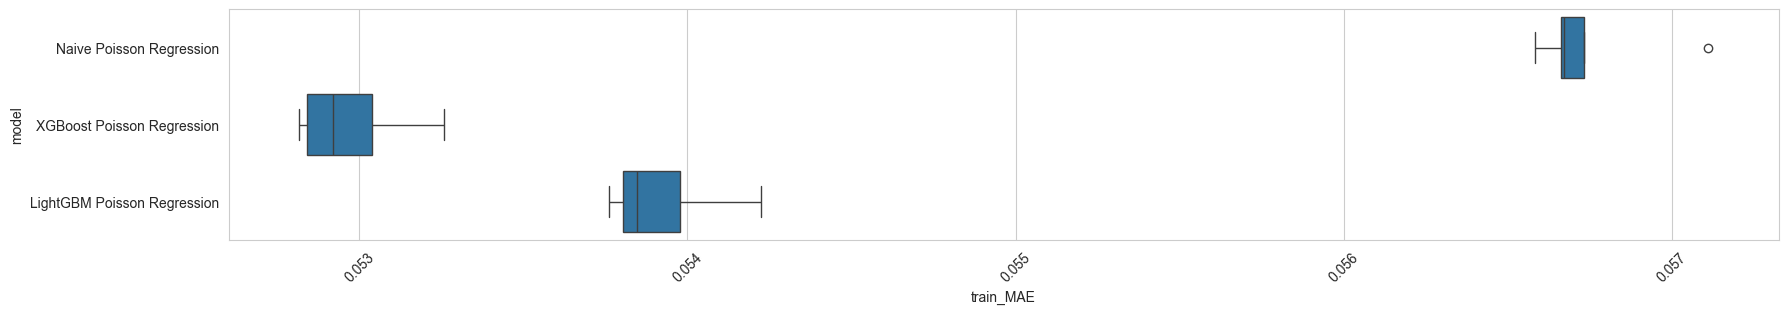

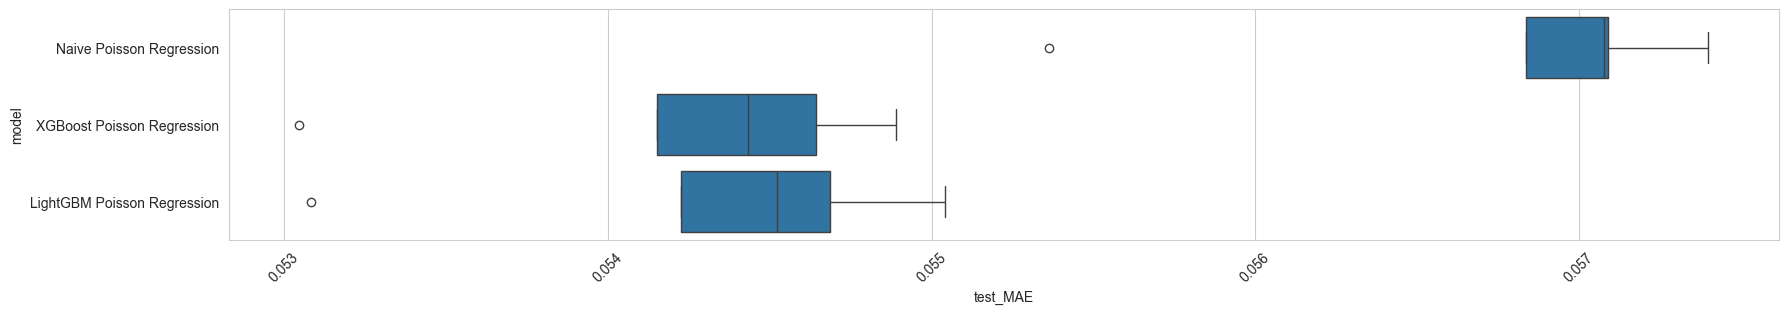

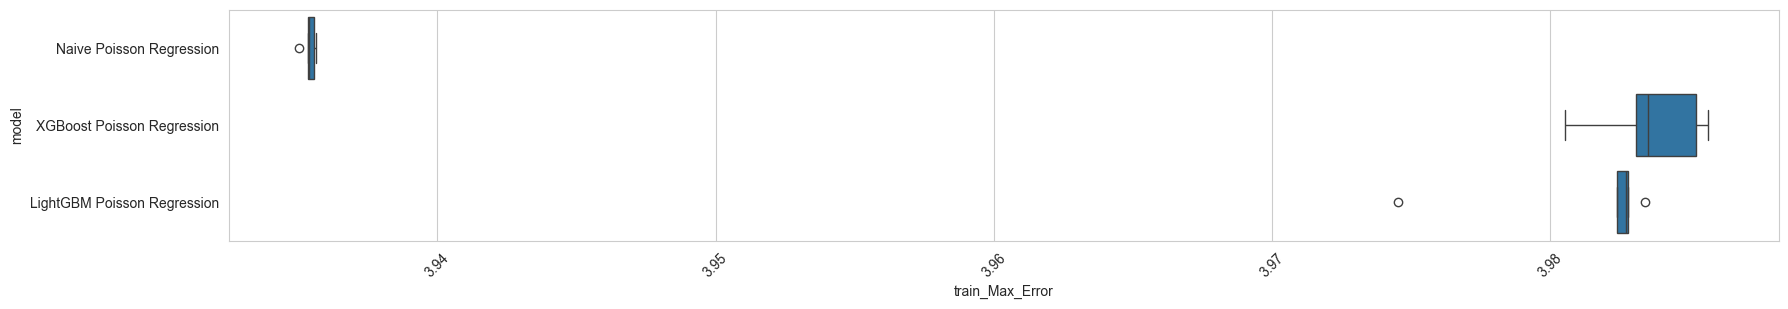

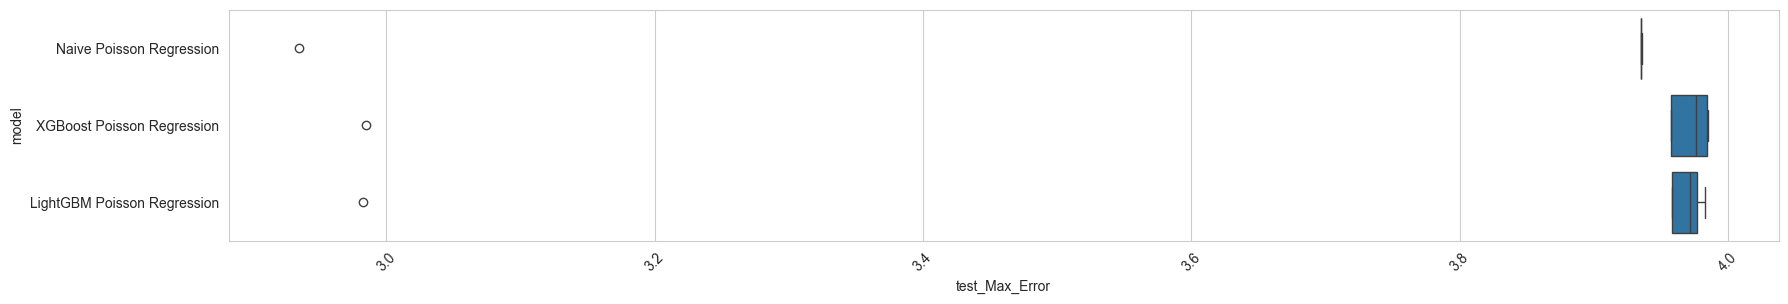

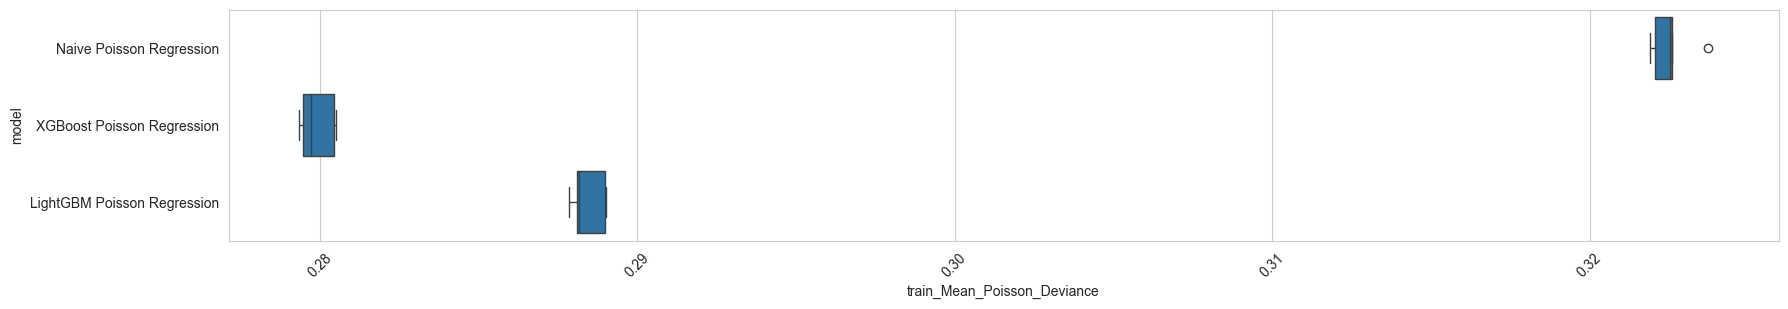

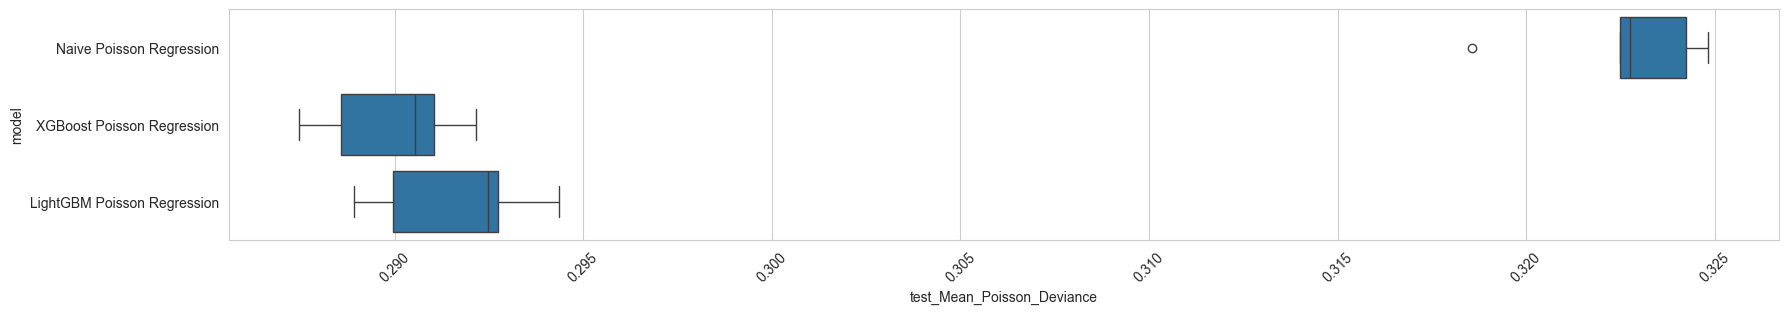

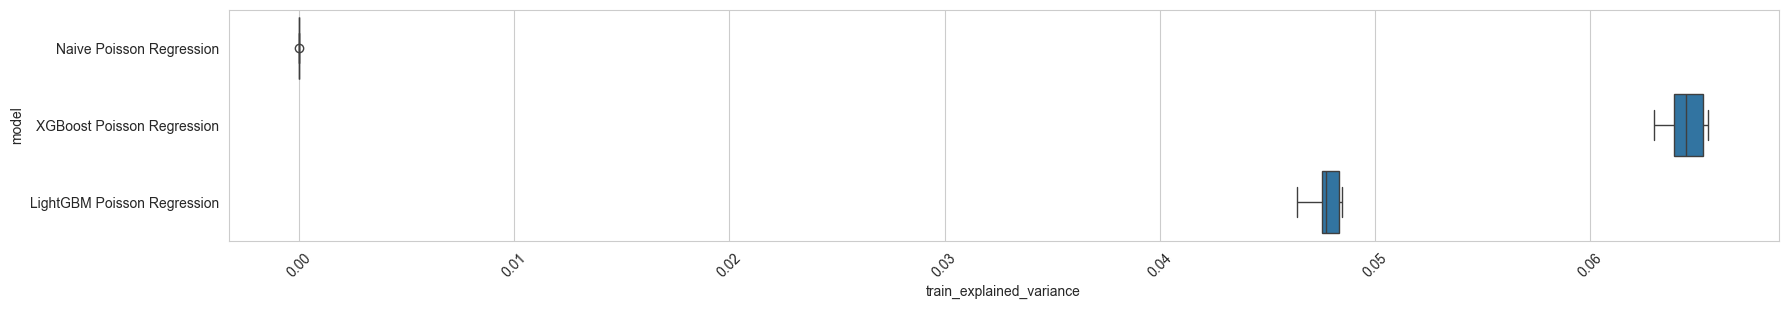

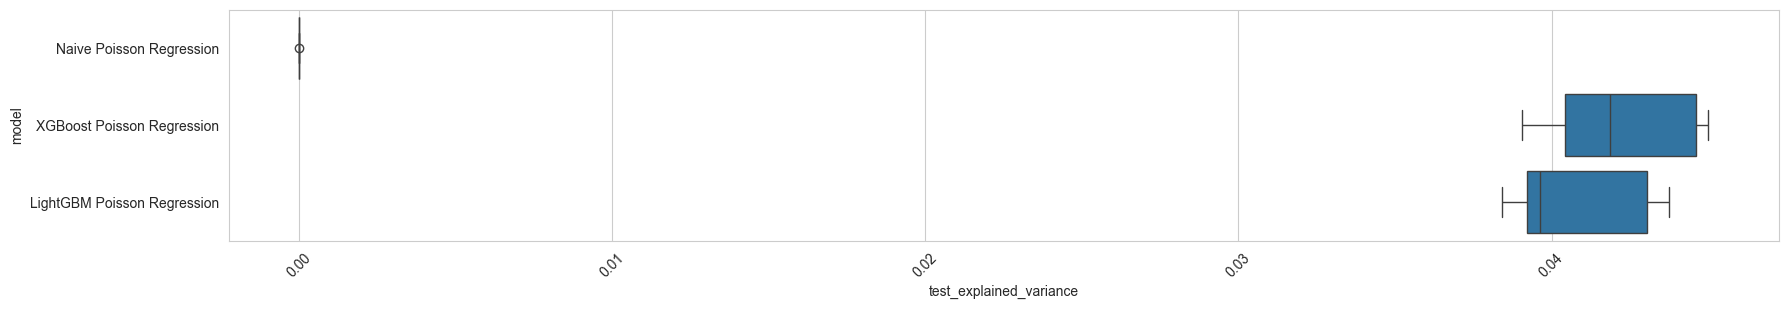

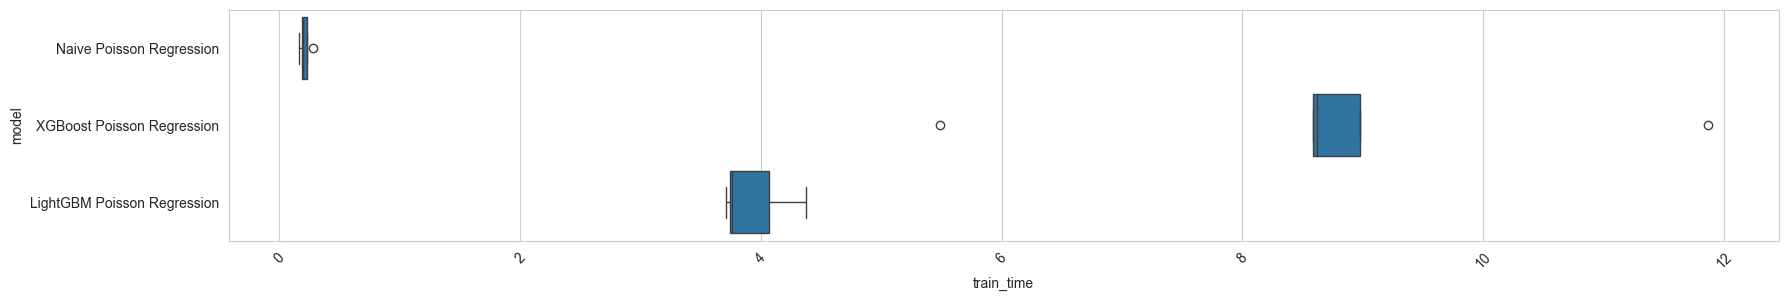

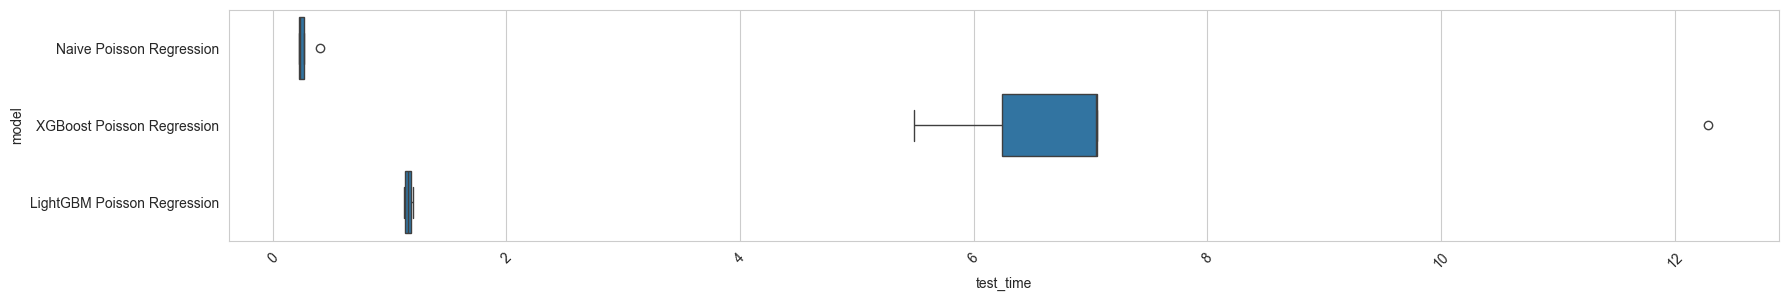

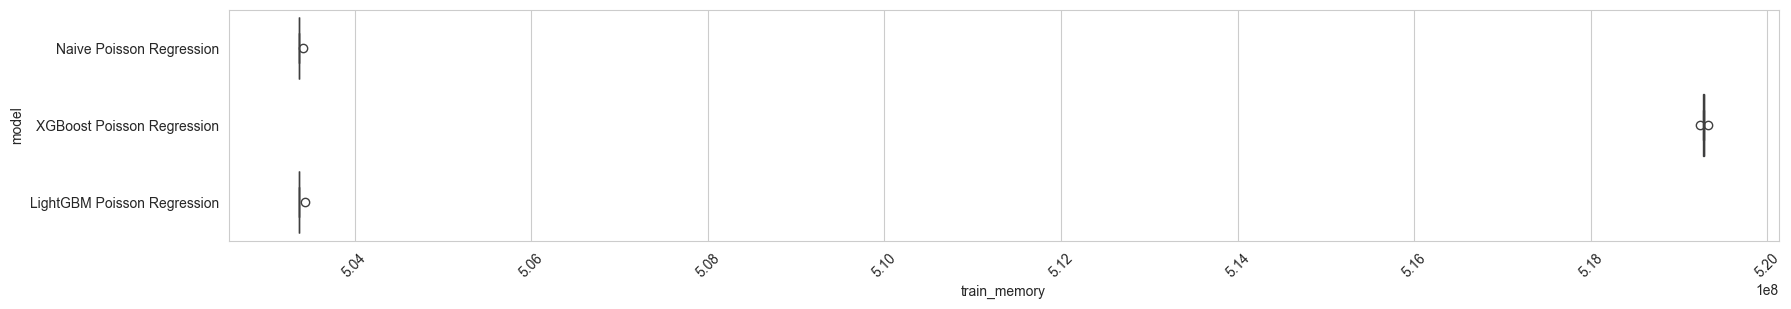

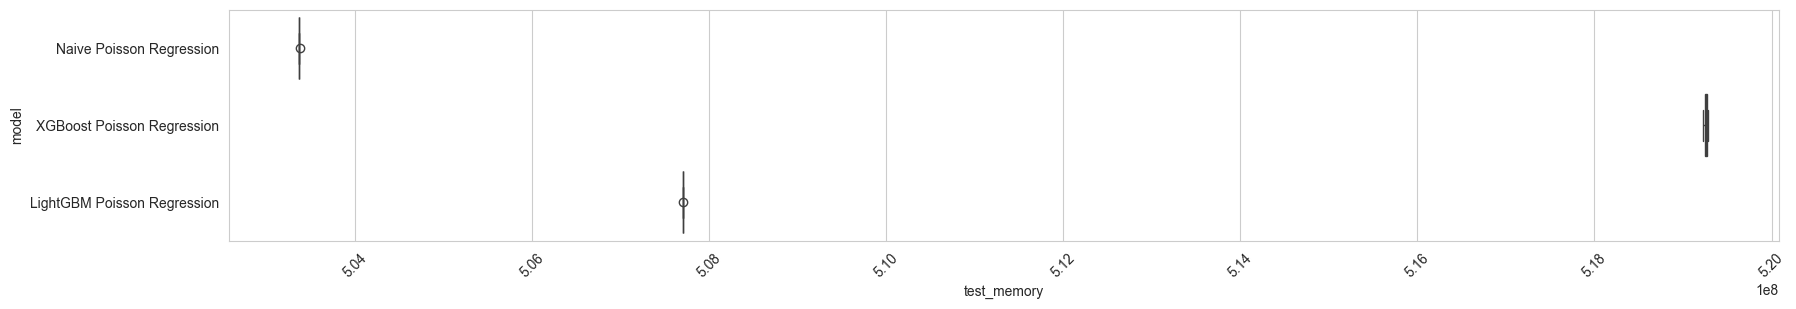

In [14]:
for metric in results[0].keys():
    if metric != "model":
        plt.figure(figsize=(20, len(results)))
        sns.boxplot(data=df_results, y="model", x=metric)
        plt.xticks(rotation=45)
        plt.show()